# Simulation Models
This notebook explains how a simulation may be set up combining several types of classes into a "Model".
We first sketch the high-level concepts and structure, before demonstrating basic usage, i.e., adjusting existing models to specific applications. 
Then, we turn to more advanced usage such as development of new models and more fundamental adjustment of existing ones.
The code and documentation of the `pp.models` module are a useful supplement to this tutorial.

## Structure and concepts
The essential parts needed to set up a simulation are the following class types:

* Geometry
* Equations
* Variables
* Constitutive laws
* Boundary conditions
* Solution strategy

The first provides the mixed-dimensional domain, the next four define the problem, whereas the last one specifies how to solve it.
Additionally, values for constant material parameters are provided as `MaterialConstants` classes and visualization is handled by a `DataSavingMixin`.

PorePy provides combinations of the above components in classes such as `SinglePhaseFlow` and `Poromechanics`. 
Since the classes are composed with relatively advanced use of Python inheritance and mixin, the (intermediate to) advanced user is highly encouraged to familiarize her/himself with those concepts.
Specifically, all class types except solution strategies are treated as Mixins.
While providing a lot of flexibility, modularity and potential for reuse across applications, the result may come across as (overwhelmingly) complex.
As a partial remedy, contracts are made explicit by class variables: Each class specifies which attributes it requires access to from other classes/mixins.
TODO: Postpone previous sentences to later section?

The  combined classes are compatible with the method `run_time_dependent_problem` as are. 
However, most users will need to adjust at least some part of the class. 
Before offering examples on minimal adjustment, we give a brief introduction to each of the components.

### Geometry
TODO: Throughout: Links to documentation of classes.
The mixed-dimensional geometry is represented in a `MixedDimensionalGrid` created and stored in a `ModelGeometry` class. 
The class contains methods for specification of fracture network geometry and meshing.
It also provides helper methods for geometric operations, e.g. mixed-dimensional extensions of geometry information such as a single-dimensional grid's face normals.

### Equations
Define balance/conservation equations as `pp.ad.Operator`s compatible with the [automatic differentiation](https://github.com/pmgbergen/porepy/blob/develop/tutorials/automatic_differentiation.ipynb) framework.
The equations are passed to a `pp.EquationSystem` orchestrating discretization and assembly as requested by the solution strategy.

### Variables
Defines primary variables and related quantities such as reference values.
Primary variables are passed to the `pp.EquationSystem`, whereas secondary variables are implicitly defined as constitutive laws.

### Constitutive laws
This class defines derived quantities in terms of primary variables, material constants, (spatial) discretizations and other derived quantities.
Some prominent examples are fluxes (Darcy, Fourier, advection), porosity, aperture and internal energy.

PorePy provides laws for a quite extensive selection of quantities and even multiple relations (density may be constant or depend on pressure and/or temperature).
The modular laws are available in a library and combined as appropriate for specific models.

Each constitutive law function has its domain (list of subdomains or interfaces) as its sole parameter and returns an `pp.ad.Operator`.

### Boundary conditions
Here, boundary condition values and types are defined.
These typically correspond to flux type terms and their discretizations.

### Solution strategy
Specifies how to solve the problem through a contract with `run_time_dependent_problem`.
The base class `pp.SolutionStrategy` provides common functionality.
The child classes corresponding to individual equations/problems provide specific discretization parameters, TODO: Finish description.

### Material constants
Material constants are stored in and accessed through `SolidConstants` and `FluidConstants` objects.
These are _not_ mixins of the combined model. 
Rather, they are specified on instantiation and assigned as the attributes `solid` and `fluid`.
These classes are an important interface for relatively minor adjustments of models, as shown in the subsequent sections.

## Application examples
### Single-phase flow
As promised above, the default models are runable without any adjustments:

In [6]:
# Ignore this cell. It's a temporary workaround until models work without fractures.
import porepy as pp
import numpy as np


class RectangularDomainOrthogonalFractures2d(pp.ModelGeometry):
    def set_fracture_network(self) -> None:
        # Length scale:
        ls = 1 / self.units.m

        num_fracs = self.params.get("num_fracs", 1)
        domain = {"xmin": 0, "xmax": 2 * ls, "ymin": 0, "ymax": 1 * ls}
        if num_fracs == 0:
            p = np.zeros((2, 0), dtype=float) * ls
            e = np.zeros((2, 0), dtype=int)
        elif num_fracs == 1:
            p = np.array([[0, 2], [0.5, 0.5]]) * ls
            e = np.array([[0], [1]])
        elif num_fracs == 2:
            p = np.array([[0, 2, 0.5, 0.5], [1, 1, 0, 1]]) * ls
            e = np.array([[0, 2], [1, 3]])
        else:
            raise ValueError("Only 0, 1 or 2 fractures supported.")
        self.fracture_network = pp.FractureNetwork2d(p, e, domain)

    def mesh_arguments(self) -> dict:
        # Length scale:
        ls = 1 / self.units.m
        return {"mesh_size_frac": 0.5 * ls, "mesh_size_bound": 0.5 * ls}


class MassBalance(
    RectangularDomainOrthogonalFractures2d,
    pp.fluid_mass_balance.SinglePhaseFlow,
):
    ...

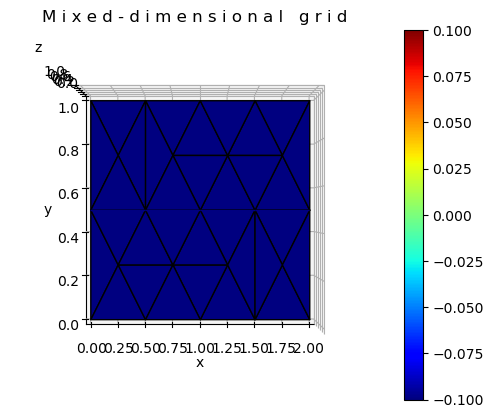

In [7]:

params = {}
single_phase = pp.fluid_mass_balance.SinglePhaseFlow(params)
single_phase = MassBalance(params)  
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure")

The empty `params` implies that unitary/zero default values are used for all constants.
Similarly, the default source term and boundary conditions are zero, resulting in absence of driving forces.
Let's change boundary conditions, geometry and the fluid constants compressibility and viscosity.

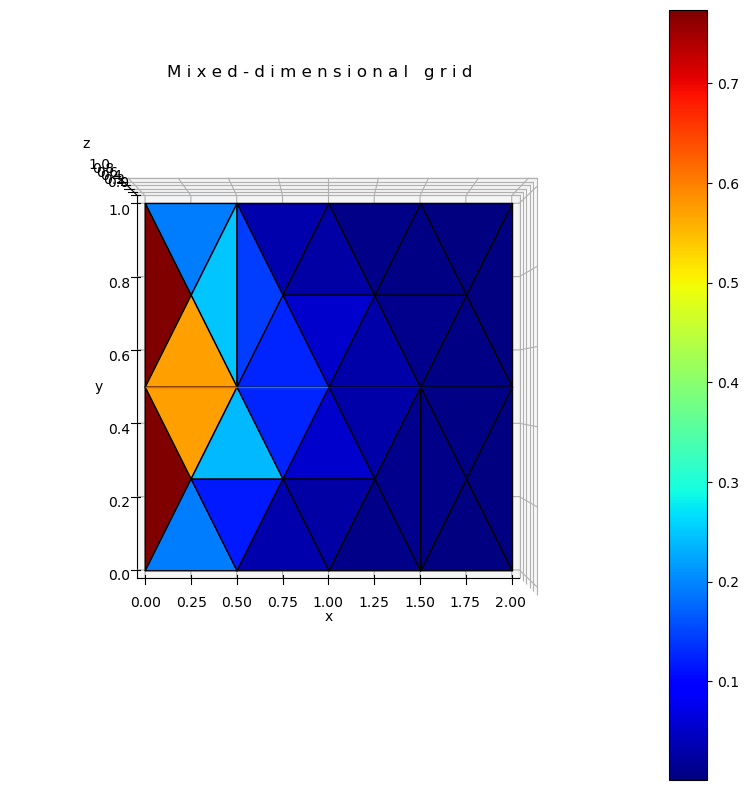

In [10]:
# Utility function to set wrap an array or matrix as an ad object
from porepy.models.constitutive_laws import ad_wrapper
class ModifiedFluidFlowBCs:
    def bc_values_darcy_flux(self, subdomains: list[pp.Grid]) -> pp.ad.Array:
        """Dirichlet value p=1 on the west boundary of the domain.
        
        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, _, west, *_ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(1, "Pa")
            values.append(val_loc)
        return ad_wrapper(np.hstack(values), True, name="bc_values_darcy")

    def bc_values_mobrho(self, subdomains: list[pp.Grid]) -> pp.ad.Array:
        """
        
        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, _, west, *_ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            val_loc[west] = self.fluid.density() / self.fluid.viscosity()
            values.append(val_loc)
        return ad_wrapper(np.hstack(values), True, name="bc_values_mobrho")

class ModifiedSinglePhaseFlow(
    RectangularDomainOrthogonalFractures2d,
    ModifiedFluidFlowBCs,
    pp.fluid_mass_balance.SinglePhaseFlow,
):
    ...

fluid = pp.FluidConstants({"compressibility": 10, "viscosity": 0.1})
params = {"fluid": fluid}
single_phase = ModifiedSinglePhaseFlow(params)
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure", figsize=(10, 10))

Notice how we defined separate classes for our modifications before combining them with the base class.
An alternative approach is to make a single modified class inheriting from `SinglePhaseFlow` and overriding both boundary condition methods and the geometry method in that class.
This may be convenient in some simple cases, but does not allow for as flexible reuse of the modifications (notice our use of `GeometrySingleFracture2d` below).


The ordering of the mixins in the inheritance paramount.
Python's method resolution order dictates that the first class/mixin takes precedence over later ones.
Thus, it is _crucial_ to place your modifications before the generic model!
Try all permutations of geometry, BCs and base model and make sure you understand the implications.

The model allows for all sorts of modifications.
In addition to changing boundary conditions and the source term, the most common alterations will be related to constitutive laws.
The list of accessed material constants in `ConstitutiveLawsSinglePhaseFlow` is a useful reference when passing custom `SolidConstants` and `FluidConstants` classes.

The other model classes are conceptually very similar to single-phase flow, albeit somewhat more complicated in the case of coupled equations.
Note that the `EnergyBalance` class is currently _not_ standalone - it is only runable in combination with other classes or with certain modifications.

## Advanced use
This section offers a deeper dive into the design principles of the simulation models.
Again, we refer to the TODO: documentation for technical implementational details.
### Primary equations
There are three single-equation models:
* `SinglePhaseFlow`
* `EnergyBalance` 
* `MomentumBalance` 

We commence our exploration by inspecting their composition using `MomentumBalance` as our example.
Compare the following to the above list of components:

In [14]:
print(pp.momentum_balance.MomentumBalance.__bases__)

(<class 'porepy.models.momentum_balance.MomentumBalanceEquations'>, <class 'porepy.models.momentum_balance.VariablesMomentumBalance'>, <class 'porepy.models.momentum_balance.ConstitutiveLawsMomentumBalance'>, <class 'porepy.models.momentum_balance.BoundaryConditionsMomentumBalance'>, <class 'porepy.models.momentum_balance.SolutionStrategyMomentumBalance'>, <class 'porepy.models.geometry.ModelGeometry'>, <class 'porepy.viz.data_saving_model_mixin.DataSavingMixin'>)


The classes are designed to not contain overlapping functionality - there should be no equation defining method in the variable class - and even quite significant adjustments might localize to a subset of the members.
Thus, a modification could e.g. take the form of designing a brand new set of constitutive laws and combining it with the base version.
The user is encouraged to consider the sometimes nontrivial question of whether the modifications impact the solution strategy.

Below, we illustrate two ways of performing an actual combination. 
The former is simpler and allows for re-definition of a subset of the constitutive laws.
The latter leads to a somewhat cleaner inheritance structure and better control of the method picked by the resolution order.
It may therefore be preferred for extensive changes. 

In [ ]:
class MyConstitutiveLaws(
    pp.constitutive_laws.ConstantAperture,
    pp.constitutive_laws.ConstantFluidDensity,
    pp.constitutive_laws.BiotCoefficient,
    pp.constitutive_laws.ThermoPressureStress,
    pp.constitutive_laws.PoroMechanicsPorosity,
):
    pass

class SimpleCombination(MyConstitutiveLaws, pp.momentum_balance.MomentumBalance):
    pass

class ElaborateCombination(
    MyConstitutiveLaws,
    pp.momentum_balance.MomentumBalance,
    pp.fluid_mass_balance.SinglePhaseFlow,
):
    """Note that strictly speaking, this does not work, since
    MyConstitutiveLaws is not exhaustive; it does not include all
    constitutive laws required by the base classes.
    
    """
    
    pass


#### Constitutive laws
Constitutive laws are treated somewhat differently from the other components in that we collect modular laws in a library.
Furthermore, the individual laws extensively access material constants.
We emphasize that this modularity is very flexible and allows implementation of any ad-compatible tailored law.

*Note:* The distinction between constitutive laws and discretization is somewhat blurry.
Discretization schemes are defined as part of constitutive laws, but impact `SolutionStrategy` (discretization parameter assignment) and `BoundaryConditions`.

#### Scaling
The material constant classes provide functionality for scaling the equations.
This is done by passing a `Units` object to the initialization params with non-unitary values for some of the SI base units.
All parameter definition is done in SI units, but computations are performed in the scaled units.
An important implication is that all numerical values of physical quantities that are set without calling a solid or fluid material function should be converted.
Prominent examples are boundary conditions, source terms and geometry definition, some of which are illustrated in the above modified classes.

### Secondary equation combinations
Multi-physics coupled equations are constructed by first merging the equation, variable etc. classes for the single-physics components.
Then, these are combined into a complete multi-physics model.
Let us sketch an incomplete example:
```
class VariablesMultiPhysics(VariablesA, VariablesB):
    pass

```
If the combined class needs more than the sum of the constituents, the following inheritance construction arises:
```
class ConstitutiveLawsMultiPhysics(
    CouplingLawOne, 
    CouplingLawTwo,
    ConstitutiveLawsA,
    ConstitutiveLawsB,
):
    pass

class SolutionStrategyMultiPhysics(
    SolutionStrategyA,
    SolutionStrategyB,
):
    def set_discretization_parameters(self):
        # Call parent methods
        super().set_discretization_parameters()
        # Assign parameters for discretization related to one of the new coupling laws
        ...

class MultiPhysics(
    VariablesMultiPhysics,
    ConstitutiveLawsMultiPhysics,
    ...,
    SolutionStrategyMultiPhysics,
):
    pass
```
For more details, see the code in `poromechanics`, `thermoporomechanics` and `fluid_and_mass_balance`.
The structure with mixins for the various parts of the model should also provide a good starting point for developing new combined equations.


In [16]:
import inspect
inspect.getmro(pp.mass_and_energy_balance.VariablesFluidMassAndEnergy)

(porepy.models.mass_and_energy_balance.VariablesFluidMassAndEnergy,
 porepy.models.energy_balance.VariablesEnergyBalance,
 porepy.models.fluid_mass_balance.VariablesSinglePhaseFlow,
 porepy.models.abstract_equations.VariableMixin,
 object)